In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!cp -r /content/drive/MyDrive/Colab\ Notebooks/\(데이콘\)운동동작분류/data ./

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Conv1D, MaxPool1D, SeparableConv1D, AvgPool1D
from tensorflow.keras.layers import Flatten, Activation, Dropout, BatchNormalization, Input, Add, GlobalAvgPool1D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [4]:
df = pd.read_csv('./data/train_features.csv')
# df

In [5]:
train_x = df.values[:,2:].reshape(-1,600,6)
train_x.shape

(3125, 600, 6)

In [6]:
df = pd.read_csv('./data/train_labels.csv')
# df

In [7]:
train_y = df.values[:,1].astype(np.int)
train_y.shape

(3125,)

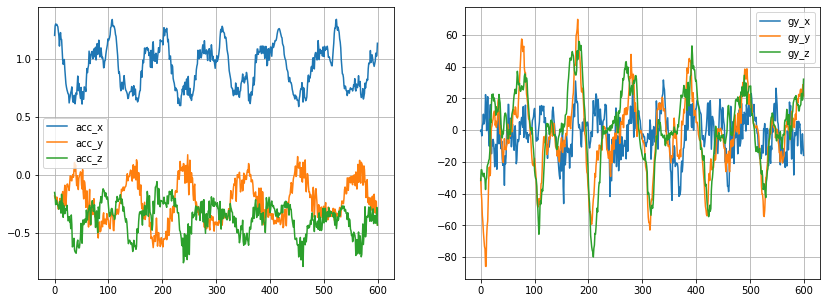

In [14]:
def show_data0(data_x):
  fig = plt.figure(figsize=(14,5))
  ax1 = fig.add_subplot(1, 2, 1)
  ax2 = fig.add_subplot(1, 2, 2)
  ax1.plot(data_x[:,0], label='acc_x')
  ax1.plot(data_x[:,1], label='acc_y')
  ax1.plot(data_x[:,2], label='acc_z')
  ax1.grid()
  ax1.legend()
  ax2.plot(data_x[:,3], label='gy_x')
  ax2.plot(data_x[:,4], label='gy_y')
  ax2.plot(data_x[:,5], label='gy_z')
  ax2.grid()
  ax2.legend()

  plt.show()

show_data0(train_x[0])

In [ ]:
f, Pxx = signal.periodogram(np.linalg.norm(train_x[103,:,:3], axis=-1))
freq_indices = np.flip(np.argsort(Pxx), 0)[0:3]
freq = f[freq_indices]
period = np.around(1 / np.array(freq))
period

array([120.,  40.,  60.])

In [ ]:
f, Pxx = signal.periodogram(np.linalg.norm(train_x[157,:,3:], axis=-1))
freq_indices = np.flip(np.argsort(Pxx), 0)[0:3]
freq = f[freq_indices]
period = np.around(1 / np.array(freq))
period

array([46., 23., 86.])

In [ ]:
np.where(train_y==55)[0]

array([ 103,  117,  157,  235,  307,  676,  751,  765,  782,  790,  819,
        842,  895,  973,  988, 1057, 1340, 1618, 1674, 1796, 2042, 2060,
       2095, 2195, 2224, 2232, 2319, 2335, 2434, 2665, 2794, 2929, 2946,
       2963, 2987, 2998, 3102])

In [ ]:
np.where(train_y==26)[0]

array([   1,    3,    4, ..., 3120, 3121, 3123])

In [ ]:
np.where(train_y==10)[0]

array([  95,  313,  408,  465,  497,  520,  918, 1184, 1218, 1342, 1495,
       1505, 1581, 1627, 2343, 2373, 2409, 2520, 2668, 2824])

In [17]:
inds = np.where(train_y==11)[0]

for ind in inds:
  print(get_period(train_x[ind]), ind)

[35, 38, 24] 237
[35, 23, 67] 243
[100, 50, 46] 351
[100, 86, 4] 445
[50, 100, 33] 687
[120, 150, 600] 835
[75, 150, 50] 985
[75, 38, 600] 1133
[38, 35, 75] 1287
[600, 16, 300] 1398
[120, 60, 67] 1455
[4, 60, 300] 1637
[50, 100, 46] 1783
[200, 150, 600] 1886
[75, 38, 25] 2051
[43, 86, 46] 2342
[150, 4, 55] 2387
[33, 67, 22] 2445
[50, 100, 33] 2534
[100, 5, 86] 2545
[100, 35, 55] 2629
[50, 100, 46] 2980
[75, 30, 600] 3030


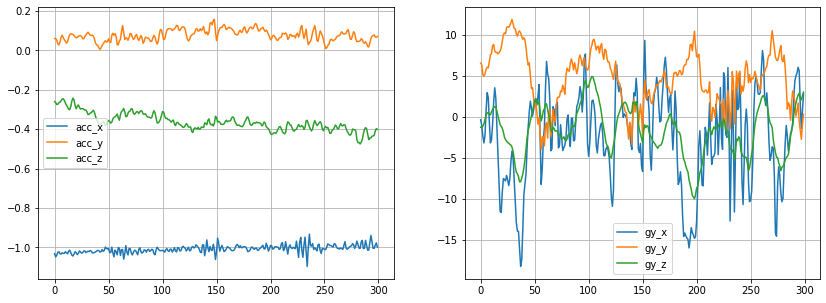

In [16]:
show_data0(train_x[1398, :300, :])

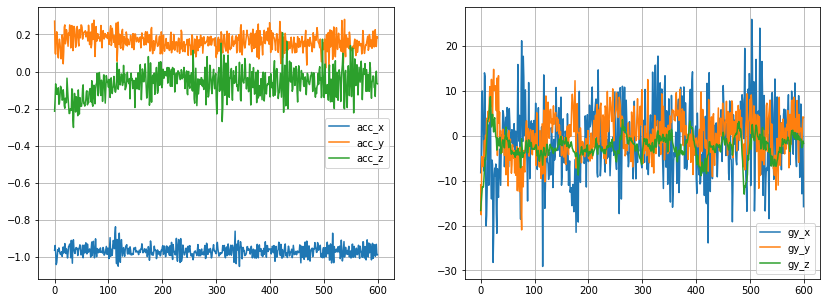

In [27]:
show_data0(train_x[1637])

In [9]:
from scipy import signal

def get_period(data_x): # (6)
  periods = []
  ch = data_x.shape[1]
  top_n = 3

  for i in range(ch):
    f, Pxx = signal.periodogram(data_x[:,i])
    freq_indices = np.flip(np.argsort(Pxx), 0)[0:top_n]
    freq = f[freq_indices]
    period = np.around(1 / np.array(freq))
    periods.append(period.tolist())
  
  periods = np.array(periods, dtype=np.int).swapaxes(0,1) # (3, ch)
  
  wei = []
  for i in range(top_n):
    wei += [0.8**i] * ch

  pers = []
  cnt = np.bincount(periods.reshape(-1), weights=wei)#[1]*ch + [0.8]*ch + [0.5]*ch)
  for i in range(3):
    per = np.argmax(cnt)
    pers.append(per)
    cnt[per] = 0

  return pers

def combi_div(arr):
  arr = sorted(arr)
  eps = 10e-8
  d1 = arr[0] / (arr[1] + eps)
  d2 = arr[0] / (arr[2] + eps)
  d3 = arr[1] / (arr[2] + eps)

  return sorted([d1, d2, d3], reverse=True)

def get_feature(data_x):
  # peri = get_period(data_x)
  # f1 = combi_div(peri)
  # return np.array(f1)
  peri1 = get_period(data_x[:,:3])
  peri2 = get_period(data_x[:,3:])
  f1 = combi_div(peri1)
  f2 = combi_div(peri2)
  return np.array(f1+f2)


In [ ]:
for i in np.where(train_y==26)[0]:
  get_feature(train_x[4])

In [10]:
get_period(train_x[103])

[120, 60, 100]

In [ ]:
print(get_feature(train_x[103]))
print(get_feature(train_x[117]))
print(get_feature(train_x[157]))
print(get_feature(train_x[235]))
print(get_feature(train_x[307]))
print(get_feature(train_x[676]))
print(get_feature(train_x[751]))
print(get_feature(train_x[765]))

[3.         2.         1.5        7.05882353 3.52941176 2.        ]
[3.48837209 2.79069767 1.25       1.5        1.25       1.2       ]
[2.17391304 1.86956522 1.1627907  1.33333333 1.1627907  1.14666667]
[2.         1.79104478 1.11666667 2.23880597 1.79104478 1.25      ]
[2.18181818 2.         1.09090909 1.39534884 1.2        1.1627907 ]
[3.  2.  1.5 3.  2.  1.5]
[12.          6.          2.          3.03030303  2.          1.51515152]
[2.3255814  1.74418605 1.33333333 2.3255814  1.74418605 1.33333333]


In [ ]:
print(get_feature(train_x[95]))
print(get_feature(train_x[313]))
print(get_feature(train_x[408]))
print(get_feature(train_x[465]))
print(get_feature(train_x[497]))
print(get_feature(train_x[520]))

[5.         4.         1.25       4.6875     3.94736842 1.1875    ]
[2.23880597 1.79104478 1.25       2.23880597 1.79104478 1.25      ]
[2.         1.72       1.1627907  4.34782609 3.33333333 1.30434783]
[2.         1.5        1.33333333 3.63636364 3.03030303 1.2       ]
[3.         1.97368421 1.52       3.         1.97368421 1.52      ]
[5.71428571 4.76190476 1.2        2.61904762 1.66666667 1.57142857]


In [ ]:
new_train_x = np.array([list(get_feature(train_x[i])) for i in range(len(train_x))])
new_train_x.shape


(3125, 6)

In [ ]:

print(np.argmax(model.predict(valid_x[11:12])))


26


In [ ]:
part_x, valid_x, part_y, valid_y = train_test_split(new_train_x, train_y, test_size=0.1)

model = tf.keras.Sequential()
model.add(Dense(6, activation='relu', input_shape=(6,)))
model.add(Dense(20, activation='relu'))
model.add(Dense(61, activation='softmax'))

opt = tf.keras.optimizers.SGD(0.001, momentum=0.9)
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['acc'])
model.fit(part_x, part_y, validation_data=(valid_x, valid_y), epochs=100)

Epoch 1/100
88/88 [==============================] - 1s 4ms/step - loss: 4.0170 - acc: 0.1757 - val_loss: 3.7066 - val_acc: 0.4792
Epoch 2/100
88/88 [==============================] - 0s 2ms/step - loss: 3.5238 - acc: 0.4957 - val_loss: 2.9886 - val_acc: 0.4792
Epoch 3/100
88/88 [==============================] - 0s 2ms/step - loss: 2.9127 - acc: 0.4887 - val_loss: 2.9075 - val_acc: 0.4792
Epoch 4/100
88/88 [==============================] - 0s 2ms/step - loss: 2.8658 - acc: 0.4903 - val_loss: 2.8923 - val_acc: 0.4792
Epoch 5/100
88/88 [==============================] - 0s 2ms/step - loss: 2.8749 - acc: 0.4840 - val_loss: 2.8807 - val_acc: 0.4792
Epoch 6/100
88/88 [==============================] - 0s 2ms/step - loss: 2.8451 - acc: 0.4885 - val_loss: 2.8699 - val_acc: 0.4792
Epoch 7/100
88/88 [==============================] - 0s 2ms/step - loss: 2.8563 - acc: 0.4825 - val_loss: 2.8607 - val_acc: 0.4792
Epoch 8/100
88/88 [==============================] - 0s 2ms/step - loss: 2.8321 - a

In [ ]:
tttt = get_period(train_x[103])
print(combi_div(tttt))

tttt = get_period(train_x[117])
print(combi_div(tttt))

tttt = get_period(train_x[157])
print(combi_div(tttt))

[2.0, 1.6666666666666667, 1.2]
[2.2388059701492535, 1.791044776119403, 1.25]
[2.1739130434782608, 1.8695652173913044, 1.1627906976744187]


In [ ]:
pers = []
# cnt = np.bincount(tttt.reshape(-1))
cnt = np.bincount(tttt1.reshape(-1), weights=[1]*6 + [0.8]*6 + [0.5]*6)
for i in range(3):
  per = np.argmax(cnt)
  pers.append(per)
  cnt[per] = 0
pers

[100, 86, 46]

In [ ]:
pers = []
# cnt = np.bincount(tttt.reshape(-1))
cnt = np.bincount(tttt2.reshape(-1), weights=[1]*6 + [0.7]*6 + [0.5]*6)
for i in range(3):
  per = np.argmax(cnt)
  pers.append(per)
  cnt[per] = 0
pers

[120, 60, 100]

In [ ]:
def combi_div(arr):
  arr = sorted(arr, reverse=True)
  d1 = arr[0] / arr[1]
  d2 = arr[0] / arr[2]
  d3 = arr[1] / arr[2]
  return [d1, d2, d3]

In [ ]:
from scipy import signal

ind = 2998
data = np.linalg.norm(train_x[ind,:,3:], axis=-1)
# f, Pxx = signal.periodogram(data)
f, Pxx = signal.periodogram(train_x[117,:,0])
# plt.plot(f,Pxx)

top_3_periods = {}

# get indices for 3 highest Pxx values
top3_freq_indices = np.flip(np.argsort(Pxx), 0)[0:3]

# use indices from previous step to
# get 3 frequencies with highest power
freqs = f[top3_freq_indices]

# use same indices to get powers as well
power = Pxx[top3_freq_indices]

# we are interested in period and it is calculated as 1/frequency 
periods = 1 / np.array(freqs)

# populate dict with calculated values
top_3_periods['period1'] = periods[0]
top_3_periods['freq1'] = freqs[0]
top_3_periods['power1'] = power[0]

top_3_periods['period2'] = periods[1]
top_3_periods['freq2'] = freqs[1]
top_3_periods['power2'] = power[1]

top_3_periods['period3'] = periods[2]
top_3_periods['freq3'] = freqs[2]
top_3_periods['power3'] = power[2]
top_3_periods

{'freq1': 0.008333333333333333,
 'freq2': 0.006666666666666667,
 'freq3': 0.005,
 'period1': 120.0,
 'period2': 150.0,
 'period3': 200.0,
 'power1': 163.3424772625235,
 'power2': 121.45958637085857,
 'power3': 18.68755210365136}

In [ ]:
from scipy import signal

ind = 157
data = np.linalg.norm(train_x[ind,:,3:], axis=-1)
# f, Pxx = signal.periodogram(data)
f, Pxx = signal.periodogram(train_x[157,:,0])
# plt.plot(f,Pxx)

top_3_periods = {}

# get indices for 3 highest Pxx values
top3_freq_indices = np.flip(np.argsort(Pxx), 0)[0:3]

# use indices from previous step to
# get 3 frequencies with highest power
freqs = f[top3_freq_indices]

# use same indices to get powers as well
power = Pxx[top3_freq_indices]

# we are interested in period and it is calculated as 1/frequency 
periods = 1 / np.array(freqs)

# populate dict with calculated values
top_3_periods['period1'] = periods[0]
top_3_periods['freq1'] = freqs[0]
top_3_periods['power1'] = power[0]

top_3_periods['period2'] = periods[1]
top_3_periods['freq2'] = freqs[1]
top_3_periods['power2'] = power[1]

top_3_periods['period3'] = periods[2]
top_3_periods['freq3'] = freqs[2]
top_3_periods['power3'] = power[2]
top_3_periods

{'freq1': 0.01,
 'freq2': 0.011666666666666667,
 'freq3': 0.008333333333333333,
 'period1': 100.0,
 'period2': 85.71428571428571,
 'period3': 120.0,
 'power1': 117.85321858825567,
 'power2': 105.33475210234865,
 'power3': 18.464165896616922}